In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl

In [27]:
movies_df = pd.read_csv("ml-latest-small/movies.csv")
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [28]:
ratings_df = pd.read_csv("ml-latest-small/ratings.csv")
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Question 1

In [29]:
total_users = ratings_df.userId.unique()
len(total_users)
all_pos_ratings = len(movies_df) * len(total_users)
sparsity = len(ratings_df) / all_pos_ratings
print("Total number of possible ratings:", all_pos_ratings)
print("Total number of available ratings:", len(ratings_df))
print("Sparsity", sparsity)

Total number of possible ratings: 5942620
Total number of available ratings: 100836
Sparsity 0.016968273253211548


## Question 2

[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


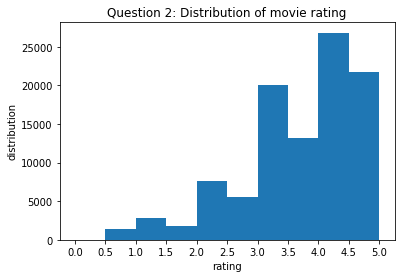

In [30]:
r_bins = [x / 10.0 for x in range(0, 51, 5)]
print(r_bins)
plt.hist(ratings_df.rating, bins=r_bins)
plt.xticks(r_bins)
plt.xlabel("rating")
plt.ylabel("distribution")
plt.title("Question 2: Distribution of movie rating")
plt.show()

The distribution is left skewed. People are more willing to rat the movies they like than rating the movies they displike.

## Question 3

In [47]:
movie_ratings = dict()
for i in range(len(ratings_df)):
    id = ratings_df.loc[i, "movieId"]
    if id in movie_ratings:
        movie_ratings[id] = movie_ratings[id] + 1
    else:
        movie_ratings[id] = 1

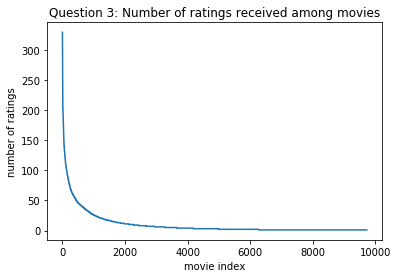

In [48]:
movie_lists = sorted(movie_ratings.items(), key=lambda x:-x[1]) #sorted by key
x_id,y_cnt = zip(*movie_lists)
xs = range(len(x_id))
plt.plot(xs, y_cnt)
plt.xlabel("movie index")
plt.ylabel("number of ratings")
plt.title("Question 3: Number of ratings received among movies")
plt.show()

## Question 4

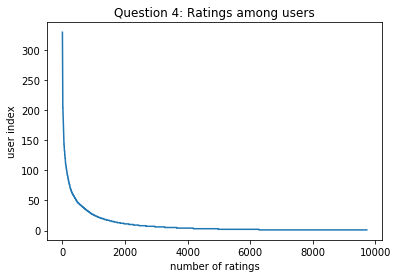

In [33]:
user_cnt = dict()
for i in range(len(ratings_df)):
    id = ratings_df.loc[i, "userId"]
    if id in user_cnt:
        user_cnt[id] = user_cnt[id] + 1
    else:
        user_cnt[id] = 1
user_list = sorted(user_cnt.items(), key=lambda x:-x[1])
user_list
u_id,y_cnt = zip(*movie_lists)
xs = range(len(u_id))
plt.plot(xs, y_cnt)
plt.xlabel("number of ratings")
plt.ylabel("user index")
plt.title("Question 4: Ratings among users")
plt.show()

## Question 5

The distribution has a really long tail, and this means that only a small portion of the movies have lots of ratings most of the movies have a small number of ratings. This means that the matrix is very sparse. The sparse matrix limits the coverage of neighborhood-based methods, and this creates challenges for robust similarity computation. But popular movie is easier to predict.

## Question 6

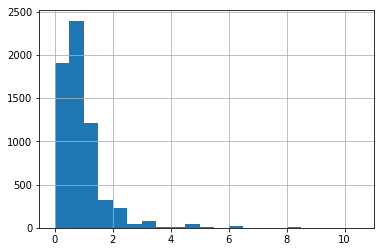

In [50]:
movie_var = ratings_df.groupby(['movieId'])['rating'].var()
movie_var.head()
max_var = movie_var.max()
min_var = movie_var.min()
v_bins = [i / 10.0 for i in range(0, 106, 5)]
movie_var.hist(bins=v_bins)
plt.show()

The distribution means that the ratings on the movies are very consistent. Most of the movie have very low variance, and only small amount of movie have high variance in terms of reviews. Therefore, it is easier to predict popular moives and harder to predict not so popular movies.

## Question 7

$\mu_u = \frac{\Sigma_{k \in I_u}r_{uk}}{|I_u|}$

## Question 8

This means the set of items have been rated both by user u and user v. When the two sets are disjoint these two sets have not rated any common item.

In [35]:
import matplotlib.pyplot as plt
from surprise.model_selection import cross_validate
from surprise import Reader, Dataset
from surprise.prediction_algorithms import KNNWithMeans

## Question 10-11

In [37]:
def knn_filter(data_set, krange):
    mae_results = []
    rmse_results = []

    for i in krange:
        result = cross_validate(KNNWithMeans(k=i, sim_options = {'name': 'pearson', 'user_base': True}, verbose=False),
                                data_set, measures=['rmse', 'mae'], cv=10, verbose=False)
        avg_mae = np.mean(result['test_mae'])
        avg_rmse = np.mean(result['test_rmse'])
        mae_results.append(avg_mae)
        rmse_results.append(avg_rmse)

#         print(i)
#         print("MAE = ", avg_mae)
#         print("RMSE = ", avg_rmse)
    print("Minimum MAE = ", min(mae_results))
    print("Minimum RMSE = ", min(rmse_results))
    plt.plot(krange, mae_results)
    plt.plot(krange, rmse_results)
    plt.show()



Minimum MAE =  0.6766779734450827
Minimum RMSE =  0.8887225912810173


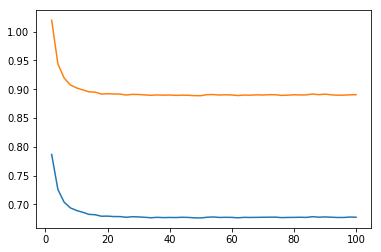

In [38]:
reader = Reader(rating_scale=(0.5, 5))
data_set = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
krange = range(2, 102, 2)
knn_filter(data_set, krange)

In [39]:
from surprise.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

## Question 12-14

In [40]:
# trim test dataset
popular_movie_df = ratings_df.groupby(['movieId']).filter(lambda x: len(x) > 2)
unpopular_movie_df = ratings_df.groupby(['movieId']).filter(lambda x: len(x) <= 2)
at_least_5_ratings_df = ratings_df.groupby(['movieId']).filter(lambda x: len(x) >= 5)
high_var_df = at_least_5_ratings_df.groupby(['movieId']).filter(lambda x: (x['rating']).var() >= 2)
print(high_var_df.shape)
print (ratings_df.shape)
print (popular_movie_df.shape)
print (unpopular_movie_df.shape)

(595, 4)
(100836, 4)
(94794, 4)
(6042, 4)


Popular Movies
Minimum MAE =  0.6619676431071577
Minimum RMSE =  0.8689759667922179


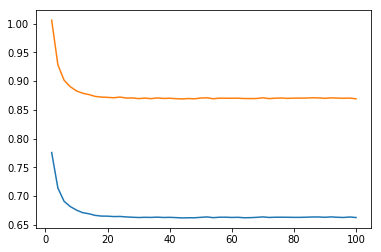

Unpopular Movies
Minimum MAE =  0.8441870772549814
Minimum RMSE =  1.0533907422876287


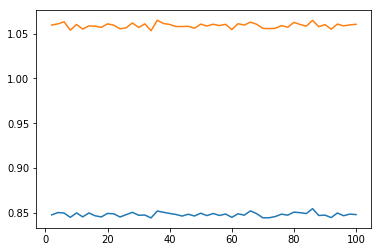

High-variance Movies
Minimum MAE =  1.0648513526545365
Minimum RMSE =  1.371434304693082


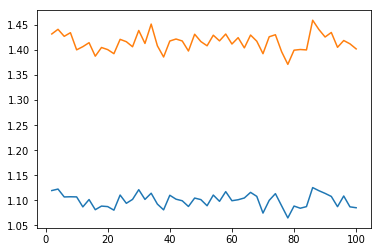

In [46]:
print("Popular Movies")
knn_filter(Dataset.load_from_df(popular_movie_df[['userId', 'movieId', 'rating']], reader), krange)
print("Unpopular Movies")
knn_filter(Dataset.load_from_df(unpopular_movie_df[['userId', 'movieId', 'rating']], reader), krange)
print("High-variance Movies")
knn_filter(Dataset.load_from_df(high_var_df[['userId', 'movieId', 'rating']], reader), krange)

## Question 15

In [47]:
def binary_predict(alg, data_set, thresholds):
    training_set, test_set = train_test_split(data_set, test_size = 0.1)
    alg.fit(training_set)
    predictions = alg.test(test_set)
    for t in thresholds:
        binary_preditions = [0 if pred.est < t else 1 for pred in predictions]
        binary_truth = [pred.r_ui for pred in predictions]
        fpr, tpr, _ = roc_curve(binary_preditions, binary_truth)
        draw_roc(fpr, tpr)

def draw_roc(fpr, tpr):
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print('AUC = ', roc_auc)
   

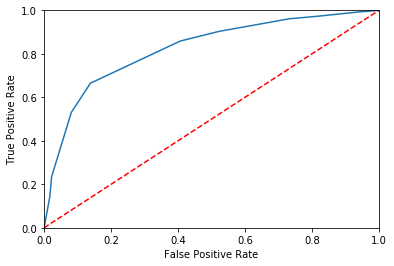

AUC =  0.8234930719945448


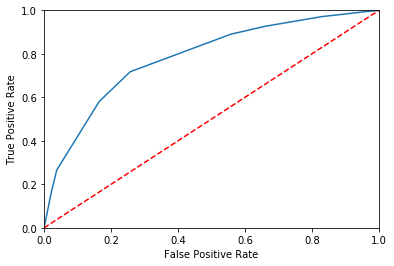

AUC =  0.7824723009062248


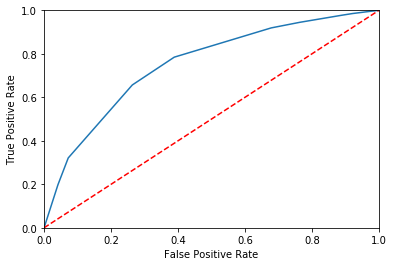

AUC =  0.7525169669665743


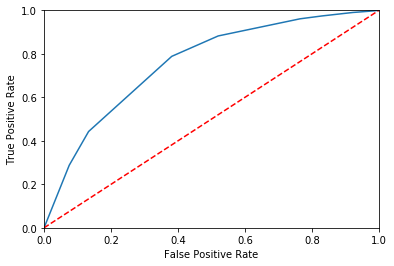

AUC =  0.7573877077501963


In [48]:
reader = Reader(rating_scale=(0.5, 5))
data_set = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
thresholds = [2.5, 3.0, 3.5, 4.0]
binary_predict(KNNWithMeans(k=18, sim_options = {'name': 'pearson', 'user_base': True}, verbose=False), data_set, thresholds)

## Question 17 - 22 NNMF

In [49]:
from surprise.prediction_algorithms.matrix_factorization import NMF

In [50]:
def nnmf_filter(data_set, krange):
    mae_results = []
    min_mae = 99999999999
    min_mae_i = -1

    rmse_results = []
    min_rmse = 9999999999
    min_rmse_i = -1

    for i in krange:
        result = cross_validate(NMF(n_factors=i, biased=False), data_set, measures=['rmse', 'mae'], cv=10, verbose=False)
        avg_mae = np.mean(result['test_mae'])
        avg_rmse = np.mean(result['test_rmse'])
        mae_results.append(avg_mae)
        rmse_results.append(avg_rmse)

        if avg_mae < min_mae:
            min_mae = avg_mae
            min_mae_i = i

        if avg_rmse < min_rmse:
            min_rmse = avg_rmse
            min_rmse_i = i
#         print(i)
#         print("MAE = ", avg_mae)
#         print("RMSE = ", avg_rmse)

    print("Best k for MAE is: ", min_mae_i, "MAE = ", min_mae)
    print("Best k for RMSE is: ", min_rmse_i, "RMSE = ", min_rmse)
    plt.plot(krange, mae_results)
    plt.plot(krange, rmse_results)
    plt.show()

Best k for MAE is:  20 MAE =  0.6934550041790116
Best k for RMSE is:  18 RMSE =  0.9121200067403998


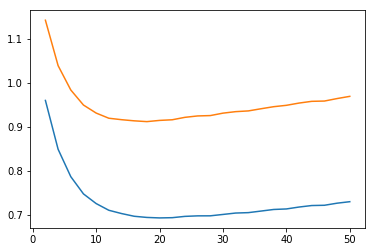

In [51]:
reader = Reader(rating_scale=(0.5, 5))
data_set = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
krange = range(2, 52, 2)
nnmf_filter(data_set, krange)

Popular Movies
Best k for MAE is:  24 MAE =  0.6803685954443075
Best k for RMSE is:  16 RMSE =  0.8925160454931088


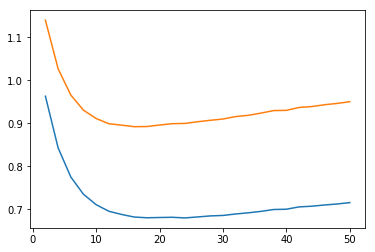

Unpopular Movies
Best k for MAE is:  40 MAE =  0.9036574125514127
Best k for RMSE is:  46 RMSE =  1.130490373196088


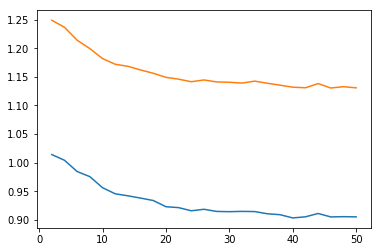

High-variance Movies
Best k for MAE is:  46 MAE =  1.1741147455766598
Best k for RMSE is:  46 RMSE =  1.4645825387093534


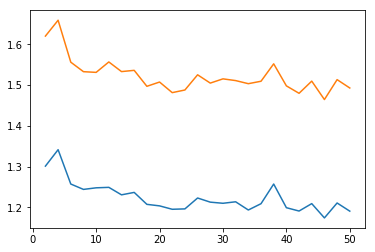

In [52]:
print("Popular Movies")
nnmf_filter(Dataset.load_from_df(popular_movie_df[['userId', 'movieId', 'rating']], reader), krange)
print("Unpopular Movies")
nnmf_filter(Dataset.load_from_df(unpopular_movie_df[['userId', 'movieId', 'rating']], reader), krange)
print("High-variance Movies")
nnmf_filter(Dataset.load_from_df(high_var_df[['userId', 'movieId', 'rating']], reader), krange)

## Question 22

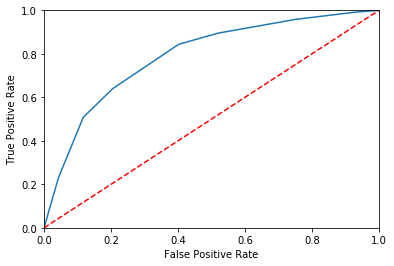

AUC =  0.7899146003655058


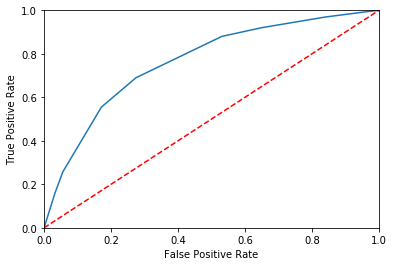

AUC =  0.7642492383327988


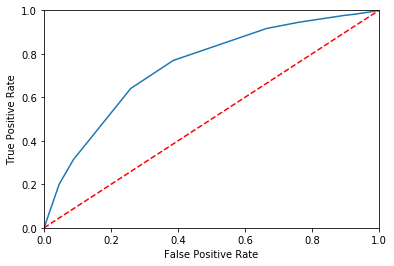

AUC =  0.7438724450034335


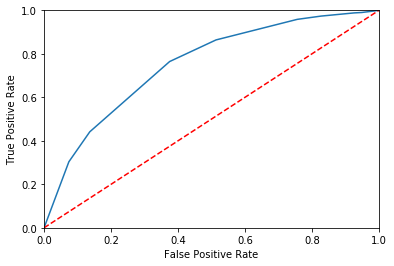

AUC =  0.7512962764389263


In [53]:
binary_predict(NMF(n_factors=18, biased=False), data_set, thresholds)

## Question 23

In [56]:
movie_to_genre = pd.read_csv('ml-latest-small/movies.csv')
movie_to_rating = pd.read_csv('ml-latest-small/ratings.csv')
movie_names = movie_to_rating.movieId.unique()
m_to_g = movie_to_genre[movie_to_genre["movieId"].isin(movie_names)]

nnmf_clf = NMF(n_factors=20, biased=False)
nnmf_clf.fit(data_set.build_full_trainset())
V = nnmf_clf.qi
print(len(list(V[:,0])))
for i in range(20):
    movies = list(V[:,i])
    moviesTuple = []
    for idx in range(len(movies)):
        moviesTuple.append((idx, movies[idx]))
    moviesTuple.sort(key = lambda x:x[1], reverse=True)
    print ("i = ", i)
    for tup in moviesTuple[0:10]:
        print (m_to_g['genres'][tup[0]])

9724
i =  0
Comedy|Drama|Romance
Drama
Comedy
Comedy|Horror|Thriller
Comedy|Crime
Horror|Sci-Fi
Action|Thriller
Crime|Drama
Crime|Mystery
Action|Crime|Thriller
i =  1
Horror
Comedy|Drama|Fantasy|Romance
Crime|Drama|Musical
Mystery|Thriller
Action|Drama|Thriller
Action|Crime|Drama|Thriller
Drama|Thriller
Drama|Thriller
Drama
Children|Drama|Fantasy
i =  2
Crime|Drama
Drama
Drama
Drama
Action|Comedy|Sci-Fi
Comedy|Drama
Adventure|Drama|Sci-Fi
Comedy|Romance
Comedy|Drama|Thriller
Drama
i =  3
Action|Drama|Thriller
Adventure|Drama
Crime|Drama|Film-Noir|Thriller
Adventure|Drama|Sci-Fi
Comedy|Romance
Drama|Horror|Thriller
Drama
Sci-Fi
Drama|Film-Noir
Drama
i =  4
Crime|Drama|Thriller
Drama
Adventure|Animation|Children|Drama|Sci-Fi
Drama
Drama|Romance|Thriller
Comedy|Sci-Fi
Drama
Drama|Horror|Thriller
Comedy|War
Drama|Fantasy|Romance
i =  5
Comedy
Comedy|Drama
Comedy|Drama
Drama
Horror|Sci-Fi
Adventure|Western
Action|Drama|Thriller
Action|Comedy
Comedy|Drama
Horror|Mystery|Thriller
i =  6
Comed

## Question 24-29 MF With Bias

In [57]:
from surprise.prediction_algorithms.matrix_factorization import SVD

In [61]:
def svd_filter(data_set, krange):
    mae_results = []
    min_mae = 99999999999
    min_mae_i = -1

    rmse_results = []
    min_rmse = 9999999999
    min_rmse_i = -1

    for i in krange:
        result = cross_validate(SVD(n_factors=i, biased=False), data_set, measures=['rmse', 'mae'], cv=10, verbose=False)
        avg_mae = np.mean(result['test_mae'])
        avg_rmse = np.mean(result['test_rmse'])
        mae_results.append(avg_mae)
        rmse_results.append(avg_rmse)

        if avg_mae < min_mae:
            min_mae = avg_mae
            min_mae_i = i

        if avg_rmse < min_rmse:
            min_rmse = avg_rmse
            min_rmse_i = i
#         print(i)
#         print("MAE = ", avg_mae)
#         print("RMSE = ", avg_rmse)

    print("Best k for MAE is: ", min_mae_i, "MAE = ", min_mae)
    print("Best k for RMSE is: ", min_rmse_i, "RMSE = ", min_rmse)
    plt.plot(krange, mae_results)
    plt.plot(krange, rmse_results)
    plt.show()

Best k for MAE is:  4 MAE =  0.7059363877940632
Best k for RMSE is:  4 RMSE =  0.9252020075385389


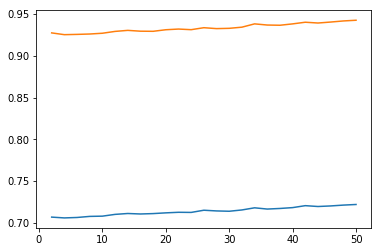

In [62]:
data_set = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
svd_filter(data_set, krange)

Popular Movies
Best k for MAE is:  8 MAE =  0.6770409043742929
Best k for RMSE is:  16 RMSE =  0.8812395875576818


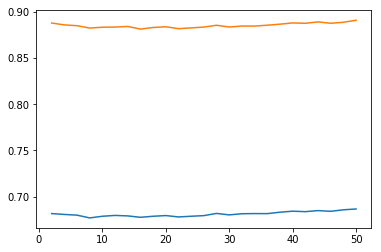

Unpopular Movies
Best k for MAE is:  6 MAE =  1.5352741885698558
Best k for RMSE is:  24 RMSE =  1.9322396842250213


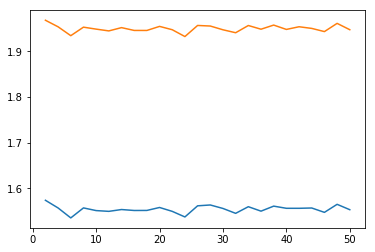

High-variance Movies
Best k for MAE is:  26 MAE =  2.1741789359603083
Best k for RMSE is:  26 RMSE =  2.5934378349570033


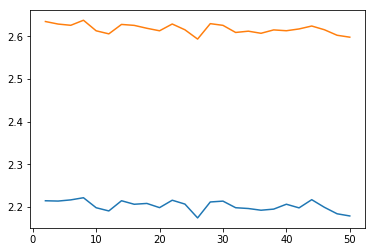

In [63]:
print("Popular Movies")
svd_filter(Dataset.load_from_df(popular_movie_df[['userId', 'movieId', 'rating']], reader), krange)
print("Unpopular Movies")
svd_filter(Dataset.load_from_df(unpopular_movie_df[['userId', 'movieId', 'rating']], reader), krange)
print("High-variance Movies")
svd_filter(Dataset.load_from_df(high_var_df[['userId', 'movieId', 'rating']], reader), krange)

## Question 29

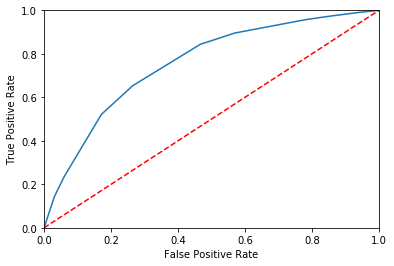

AUC =  0.7559713318289734


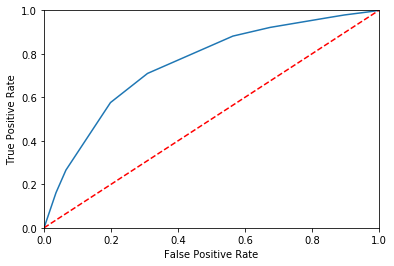

AUC =  0.7521800858429373


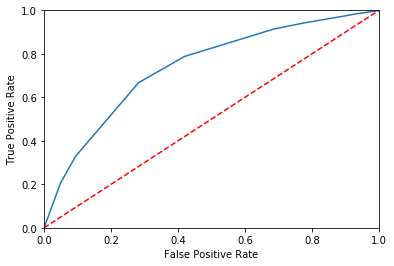

AUC =  0.7385882352941177


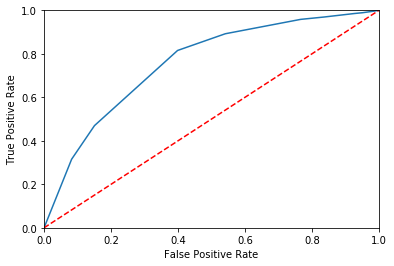

AUC =  0.7578266705452151


In [65]:
binary_predict(SVD(n_factors=4, biased=False), data_set, thresholds)

# Navie Collaborative Filtering

In [105]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

## Question 30

In [106]:
class NaiveCollabFilter:
    
    def __init__(self, ratings_df):
        self.user_means = ratings_df.groupby(['userId'])['rating'].mean()
        self.total_mean = ratings_df["rating"].mean()
    
    def predictCollab(self, user_id):
        if user_id in self.user_means.index:
            return self.user_means[user_id]
        else:
            return self.total_mean
    
clf = NaiveCollabFilter(ratings_df)

In [107]:
def K_FoldCollab(given_df):
    kf = KFold(n_splits = 10, shuffle=True)
    kf.get_n_splits(given_df)
    rmse = list()
    for train_idx, test_idx in kf.split(given_df):
        print ("processing")
        clf = NaiveCollabFilter(given_df.iloc[train_idx])
        y_pred = list()
        y_true = list()
        for t_idx in test_idx:
            user_id = given_df.iloc[t_idx].userId
            y_pred.append(clf.predictCollab(user_id))
            y_true.append(given_df.iloc[t_idx].rating)
        rmse.append(mean_squared_error(y_true, y_pred)**(1/2))
    print (rmse)
    print("Average RMSE: ", np.average(rmse))
K_FoldCollab(ratings_df)

processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
[0.9407665177218398, 0.941453901301321, 0.9361629339217006, 0.9380051635507416, 0.934161513445694, 0.941506329673521, 0.9396801161320192, 0.9423750086426163, 0.9416632623277399, 0.9541325272295417]
Average RMSE:  0.9409907273946734


## Question 31

In [108]:
popular_movie_df = ratings_df.groupby(['movieId']).filter(lambda x: len(x) > 2)
K_FoldCollab(popular_movie_df)

processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
[0.9459880176747286, 0.9384251113744843, 0.9311299022772981, 0.9398118083394815, 0.9305849704559016, 0.936149692052525, 0.9328483797229609, 0.9408594320925973, 0.9406445720512261, 0.9382180191395508]
Average RMSE:  0.9374659905180754


## Question 32

In [109]:
unpopular_movie_df = ratings_df.groupby(['movieId']).filter(lambda x: len(x) <= 2)
K_FoldCollab(unpopular_movie_df)

processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
[0.9213225951110378, 0.8753181570507349, 0.8790291614441124, 0.9313582614887248, 0.9131977366732966, 0.8844487431326967, 0.8773837597173177, 0.8931838856866903, 0.8814259071142284, 0.9112238040885402]
Average RMSE:  0.8967892011507379


## Question 33

In [114]:
at_least_5_ratings_df = ratings_df.groupby(['movieId']).filter(lambda x: len(x) >= 5)
high_var_df = at_least_5_ratings_df.groupby(['movieId']).filter(lambda x: (x['rating']).var() >= 2)
K_FoldCollab(high_var_df)

processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
[1.3980763082022107, 1.5824506116748753, 1.4210315773653637, 1.60794730576822, 1.2783196288904874, 1.1783632597365736, 1.2759714224336107, 1.489567185211815, 1.385193984778796, 1.352941410914258]
Average RMSE:  1.3969862694976212


## Question 34

In [68]:
def draw_plots(data_set):
    training_set, test_set = train_test_split(data_set, test_size = 0.1)
    
    alg1 = KNNWithMeans(k=18, sim_options = {'name': 'pearson', 'user_base': True}, verbose=False)
    alg2 = NMF(n_factors=18, biased=False)
    alg3 = SVD(n_factors=4, biased=False)
    
    alg1.fit(training_set)
    alg2.fit(training_set)
    alg3.fit(training_set)
    
    predictions1 = alg1.test(test_set)
    predictions2 = alg2.test(test_set)
    predictions3 = alg3.test(test_set)
    
    binary_preditions1 = [0 if pred.est < 3 else 1 for pred in predictions1]
    binary_preditions2 = [0 if pred.est < 3 else 1 for pred in predictions2]
    binary_preditions3 = [0 if pred.est < 3 else 1 for pred in predictions3]
    binary_truth = [pred.r_ui for pred in predictions1]
    
    fpr1, tpr1, _ = roc_curve(binary_preditions1, binary_truth)
    fpr2, tpr2, _ = roc_curve(binary_preditions2, binary_truth)
    fpr3, tpr3, _ = roc_curve(binary_preditions3, binary_truth)
    plt.title("ROC Curve Comparison")
    plt.ylabel("FPR")
    plt.xlabel("TPR")
    plt.plot(fpr1, tpr1, label = "KNN")
    plt.plot(fpr2, tpr2, label = "NNMF")
    plt.plot(fpr3, tpr3, label = "MF Biased")
    plt.plot([0, 1], [0, 1],'r--')
    plt.legend()
    plt.show()

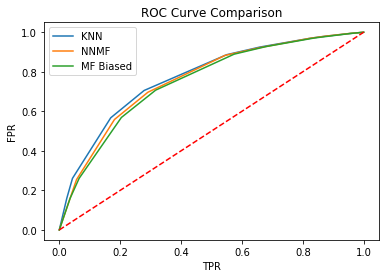

In [69]:
draw_plots(data_set)

## Question 35

Precision: The percentage of recommended items that are liked by the users. This measures how many recommned items are liked by the users.
Recall: The percentage of the liked items that are recommended to the users. This basically measures how many liked items have been recommended.

## Question 36

In [ ]:
def user_ranking(clf_str, training_set_df, test_set_df):
    if clf_str == "MF":
        clf = SVD(n_factors=16, biased=False)
    elif clf_str == "NNMF":
        clf = NMF(n_factors=16, biased=False)
    elif clf_str == "KNN":
        clf = KNNWithMeans(k=16, sim_options = {'name': 'pearson', 'user_base': True}, verbose=False)
    reader = Reader(rating_scale=(0.5, 5))
    training_set = Dataset.load_from_df(training_set_df[['userId', 'movieId', 'rating']], reader).build_full_trainset()
    test_set = Dataset.load_from_df(test_set_df[['userId', 'movieId', 'rating']], reader).build_full_trainset().build_testset()
    clf.fit(training_set)
    predictions = clf.test(test_set)
    
    pred_per_user = {}
    for pred in predictions:
        uid = pred.uid
        if uid not in pred_per_user:
            pred_per_user[uid] = [pred]
        else:
            pred_per_user[uid].append(pred)
    result = {}
#     result_test={}
    for uid in pred_per_user:
        pred_per_user[uid].sort(key = lambda x:x.est, reverse=True)
#         result_test[uid] = [x.est for x in pred_per_user[uid]]
        result[uid] = [x.iid for x in pred_per_user[uid]]
    return result

In [96]:
def getPreciAndRecall(pred_res, g_truth, t):
    true_pos = 0
    for i in range(t):
        if pred_res[i] in g_truth:
            true_pos += 1
    recall = float(true_pos)/ len(g_truth)
    return (float(true_pos) / t, recall)

def averagePreciAndRecall(all_user_res, all_g_truth, t):
    total_preci = 0
    total_recall = 0
    user_cnt = 0
    user_num = len(all_user_res)
    for user in all_user_res:
        if (user not in all_g_truth) or (len(all_user_res[user])) < t:
            user_num -= 1
            continue
        preci, recall = getPreciAndRecall(all_user_res[user], all_g_truth[user], t)
        total_preci += preci
        total_recall += recall
    return (float(total_preci)/user_num, float(total_recall)/user_num)

def getAllTruth(all_user_res, ratings_df):
    all_g_truth = dict()
    for user in all_user_res:
        res_df = ratings_df[(ratings_df["userId"]==user) & (ratings_df["rating"] >= 3.0)]
        if len(res_df) == 0: #drop 0 ground truth
            continue
        all_g_truth[user] = res_df["movieId"].unique().tolist()
#         print ("user: ", user)
#         print (all_g_truth[user])
    return all_g_truth

In [16]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
def K_FoldAverage(given_df, clf_str):
    kf = KFold(n_splits = 10, shuffle=True)
    kf.get_n_splits(given_df)
    rmse = list()
    preci_to_all_ts = dict()
    recall_to_all_ts = dict()
    for train_idx, test_idx in kf.split(given_df):
        print ("processing")
        train_df = given_df.iloc[train_idx]
        test_df = given_df.iloc[test_idx]
        print (len(test_df), len(train_df))
        all_user_res = user_ranking(clf_str, train_df, test_df)
        all_g_truth = getAllTruth(all_user_res, test_df)
        for t in range(1, 26):
            if t not in preci_to_all_ts:
                preci_to_all_ts[t] = list()
                recall_to_all_ts[t] = list()
            preci, recall = averagePreciAndRecall(all_user_res, all_g_truth, t)
            preci_to_all_ts[t].append(preci)
            recall_to_all_ts[t].append(recall)
    preci_avg = dict()
    recall_avg = dict()
    for t in range(1, 26):
        preci_avg[t] = np.mean(preci_to_all_ts[t])
        recall_avg[t] = np.mean(recall_to_all_ts[t])
    return (preci_avg, recall_avg)


processing
10084 90752
processing
10084 90752
processing
10084 90752
processing
10084 90752
processing
10084 90752
processing
10084 90752
processing
10083 90753
processing
10083 90753
processing
10083 90753
processing
10083 90753


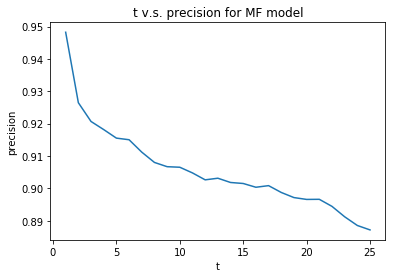

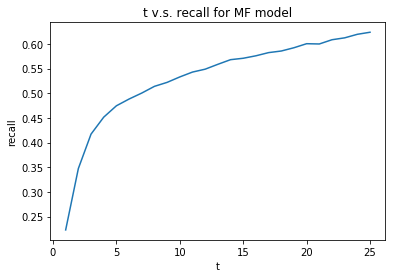

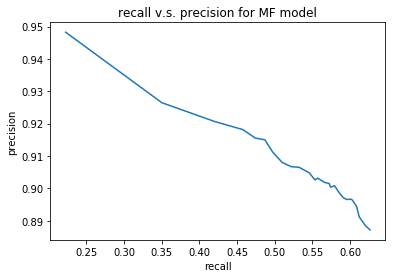

In [36]:
preci_to_all_ts, recall_to_all_ts = K_FoldAverage(ratings_df, "MF")

t_s = range(1, 26)
preci_list_mf = [preci_to_all_ts[t] for t in t_s]
plt.plot(t_s, preci_list_mf)
plt.xlabel("t");
plt.ylabel("precision")
plt.title("t v.s. precision for MF model")
plt.show()

t_s = range(1, 26)
recall_list_mf = [recall_to_all_ts[t] for t in t_s]
plt.xlabel("t");
plt.ylabel("recall");
plt.title("t v.s. recall for MF model")
plt.plot(t_s, recall_list)
plt.show()

plt.plot(recall_list_mf, preci_list_mf)
plt.title("recall v.s. precision for MF model")
plt.ylabel("precision")
plt.xlabel("recall")
plt.show()

Precision v.s. t plot: The plot is not monotonic, but as you include more times into the plot, it is less likely to maintain a very high precision. 

Recall v.s. t plot: In contrast, if you include more items, it is more likely you will include some items that are liked by the users. If you include all the items the recall will be 1. Therefore, the recall curve is monotonically increasing.

Precision v.s. recall plot: There is an inverse linear relationship between precision and recall. The value of precision decreases, when precision increases.

## Question 37

processing
10084 90752
processing
10084 90752
processing
10084 90752
processing
10084 90752
processing
10084 90752
processing
10084 90752
processing
10083 90753
processing
10083 90753
processing
10083 90753
processing
10083 90753


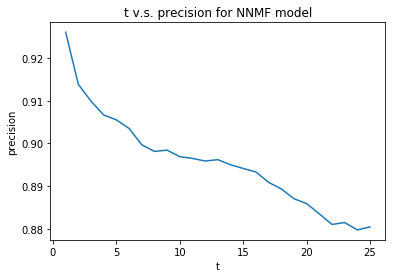

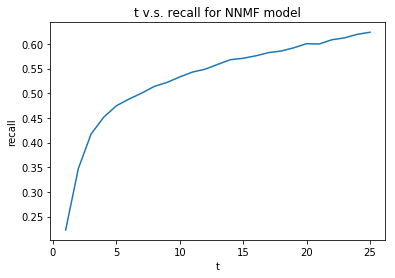

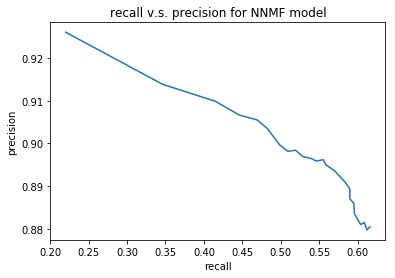

In [37]:
preci_to_all_ts, recall_to_all_ts = K_FoldAverage(ratings_df, "NNMF")

t_s = range(1, 26)
preci_list_nnmf = [preci_to_all_ts[t] for t in t_s]
plt.plot(t_s, preci_list_nnmf)
plt.xlabel("t");
plt.ylabel("precision")
plt.title("t v.s. precision for NNMF model")
plt.show()

t_s = range(1, 26)
recall_list_nnmf = [recall_to_all_ts[t] for t in t_s]
plt.xlabel("t");
plt.ylabel("recall");
plt.title("t v.s. recall for NNMF model")
plt.plot(t_s, recall_list)
plt.show()

plt.plot(recall_list_nnmf, preci_list_nnmf)
plt.title("recall v.s. precision for NNMF model")
plt.ylabel("precision")
plt.xlabel("recall")
plt.show()

Precision v.s. t plot: The plot is not monotonic, but as you include more items into the plot, it is less likely to maintain a very high precision. 

Recall v.s. t plot: In contrast, if you include more items, it is more likely you will include some items that are liked by the users. If you include all the items the recall will be 1. Therefore, the recall curve is monotonically increasing.

Precision v.s. recall plot: There is an inverse relationship between precision and recall. The value of precision decreases, when precision increases.

## Question 38

processing
10084 90752
processing
10084 90752
processing
10084 90752
processing
10084 90752
processing
10084 90752
processing
10084 90752
processing
10083 90753
processing
10083 90753
processing
10083 90753
processing
10083 90753


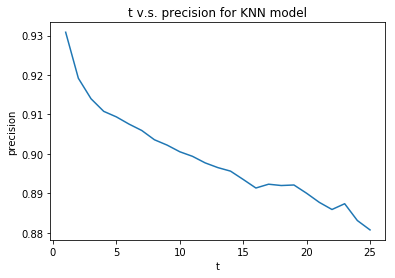

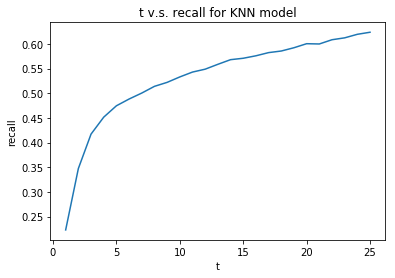

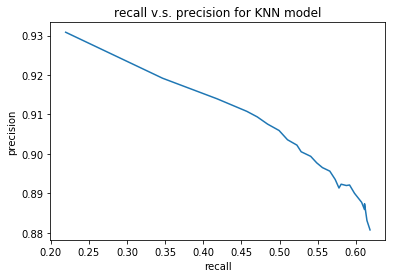

In [38]:
preci_to_all_ts, recall_to_all_ts = K_FoldAverage(ratings_df, "KNN")

t_s = range(1, 26)
preci_list_knn = [preci_to_all_ts[t] for t in t_s]
plt.plot(t_s, preci_list_knn)
plt.xlabel("t");
plt.ylabel("precision")
plt.title("t v.s. precision for KNN model")
plt.show()

t_s = range(1, 26)
recall_list_knn = [recall_to_all_ts[t] for t in t_s]
plt.xlabel("t");
plt.ylabel("recall");
plt.title("t v.s. recall for KNN model")
plt.plot(t_s, recall_list)
plt.show()

plt.plot(recall_list_knn, preci_list_knn)
plt.title("recall v.s. precision for KNN model")
plt.ylabel("precision")
plt.xlabel("recall")
plt.show()

Precision v.s. t plot: The plot is not monotonic, but as you include more items into the plot, it is less likely to maintain a very high precision. 

Recall v.s. t plot: In contrast, if you include more items, it is more likely you will include some items that are liked by the users. If you include all the items the recall will be 1. Therefore, the recall curve is monotonically increasing.

Precision v.s. recall plot: There is an inverse relationship between precision and recall. The value of precision decreases, when precision increases.

## Question 39

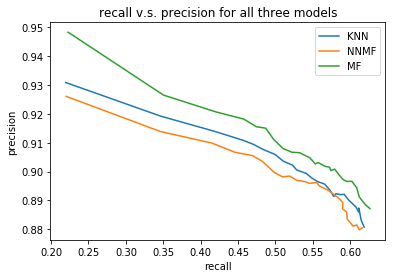

In [43]:
plt.plot(recall_list_knn, preci_list_knn, label='KNN')
plt.plot(recall_list_nnmf, preci_list_nnmf, label='NNMF')
plt.plot(recall_list_mf, preci_list_mf, label='MF')
plt.title("recall v.s. precision for all three models")
plt.ylabel("precision")
plt.xlabel("recall")
plt.legend(loc='best')
plt.show()

Both three curves share the similar trends, and the MF curve tend to have better precision and recall curve. Therefore, the MF is more suitable for the ranking task of the given data.